In [24]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
data_df = pd.read_excel('qqs_plant_roots_data.xlsx', header=1)
df = data_df.copy()

In [26]:
data_df

,Name,Individule Root Weight (g),Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Number of Roots,Total weight (g)
0,QQS-3,220.11,36.85,33.36,17.24,20.74,10.69,NaN,NaN,NaN,NaN,NaN,NaN,5.0,338.99
1,QQS-5,251.90,190.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,442.51
2,QQS-7,409.90,200.67,94.16,49.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,754.57
3,QQS-10,123.99,60.59,72.92,44.08,36.27,33.03,20.64,22.57,38.51,12.83,NaN,NaN,10.0,465.43
4,QQS-10,136.05,153.16,61.58,53.65,48.40,62.08,32.10,27.53,27.66,NaN,NaN,NaN,9.0,602.21
5,EV,115.19,138.11,58.22,40.04,25.44,16.91,10.92,13.13,5.95,5.75,5.44,NaN,11.0,435.10
6,WT,278.33,242.85,52.88,88.10,28.04,7.37,8.06,8.33,NaN,NaN,NaN,NaN,8.0,713.96
7,Note: Replication 1: Planted on 4/23/25 plante...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,QQS-3,286.75,202.63,156.96,58.26,76.80,17.17,NaN,NaN,NaN,NaN,NaN,NaN,6.0,798.57


In [27]:
# find indices of the 'note' rows which separate the replications
note_indices = df[df['Name'].astype(str).str.contains('Note:', na=False)].index

# assign replication numbers based on the note row indices
if len(note_indices) > 0:
    df.loc[0:note_indices[0], 'Replication'] = 1
if len(note_indices) > 1:
    # assign rep 2 from after first note up to and including second note
    df.loc[note_indices[0]:note_indices[1], 'Replication'] = 2
if len(note_indices) > 2:
    # assign rep 3 from after second note up to and including third note
    df.loc[note_indices[1]:note_indices[2], 'Replication'] = 3
elif len(note_indices) == 2: # handle case with only 2 note rows
    # assign rep 3 from after second note to the end
    df.loc[note_indices[1]:, 'Replication'] = 3


In [28]:
# drop rows that are not data (e.g., all-NaN rows, note rows)
df.dropna(subset=['Name'], inplace=True)
df = df[~df['Name'].astype(str).str.contains('Note:', na=False)]

# create 'plant_type' column based on exact matches or prefixes
df['Plant_Type'] = 'Other' # Default category
df.loc[df['Name'].str.startswith('QQS', na=False), 'Plant_Type'] = 'QQS'
df.loc[df['Name'].str.fullmatch('EV', na=False), 'Plant_Type'] = 'EV'
df.loc[df['Name'].str.fullmatch('WT', na=False), 'Plant_Type'] = 'WT'

# Filter to keep *only* the data rows we care about (QQS, EV, WT)
# This also effectively removes the text footer rows
df = df[df['Plant_Type'].isin(['QQS', 'EV', 'WT'])].copy()

# Rename column for easier formula syntax in statsmodels
df.rename(columns={'Total weight (g)': 'Total_Weight_g'}, inplace=True)

# Drop any rows that might have missing weight data
clean_df = df.dropna(subset=['Total_Weight_g']).copy()

# Set correct data types for categorical analysis
clean_df['Total_Weight_g'] = pd.to_numeric(clean_df['Total_Weight_g'])
clean_df['Replication'] = clean_df['Replication'].astype('category')
clean_df['Plant_Type'] = clean_df['Plant_Type'].astype('category')

# --- 3. Save Cleaned Data ---
clean_df.to_csv('qqs_plant_roots_cleaned.csv', index=False)
print("Cleaned data saved as 'qqs_plant_roots_cleaned.csv'")

Cleaned data saved as 'qqs_plant_roots_cleaned.csv'


stats

In [29]:
# --- 4. Perform ANOVA ---
print("\n--- Two-Way ANOVA Results ---")
# Fit the two-way ANOVA model
# C() treats the variables as categorical
model = ols('Total_Weight_g ~ C(Replication) + C(Plant_Type)', data=clean_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# --- 5. Perform Tukey's Post-Hoc Test ---
print("\n--- Tukey's HSD Post-Hoc Test for Plant_Type ---")
# This tells us which specific groups are different from each other
tukey_results = pairwise_tukeyhsd(clean_df['Total_Weight_g'], clean_df['Plant_Type'], alpha=0.05)
print(tukey_results)


--- Two-Way ANOVA Results ---
                       sum_sq    df          F    PR(>F)
C(Replication)  503392.901616   2.0  10.970786  0.001618
C(Plant_Type)    11905.761031   2.0   0.259470  0.775362
Residual        298251.550972  13.0        NaN       NaN

--- Tukey's HSD Post-Hoc Test for Plant_Type ---
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
    EV    QQS 260.9236 0.5343 -360.6284 882.4756  False
    EV     WT 252.6267 0.6205 -440.7436 945.9969  False
   QQS     WT  -8.2969 0.9982 -390.3253 373.7315  False
-------------------------------------------------------


plotting

In [31]:
clean_df

,Name,Individule Root Weight (g),Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Number of Roots,Total_Weight_g,Replication,Plant_Type
0,QQS-3,220.11,36.85,33.36,17.24,20.74,10.69,NaN,NaN,NaN,NaN,NaN,NaN,5.0,338.99,1.0,QQS
1,QQS-5,251.90,190.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,442.51,1.0,QQS
2,QQS-7,409.90,200.67,94.16,49.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,754.57,1.0,QQS
3,QQS-10,123.99,60.59,72.92,44.08,36.27,33.03,20.64,22.57,38.51,12.83,NaN,NaN,10.0,465.43,1.0,QQS
4,QQS-10,136.05,153.16,61.58,53.65,48.40,62.08,32.10,27.53,27.66,NaN,NaN,NaN,9.0,602.21,1.0,QQS
5,EV,115.19,138.11,58.22,40.04,25.44,16.91,10.92,13.13,5.95,5.75,5.44,NaN,11.0,435.10,1.0,EV
6,WT,278.33,242.85,52.88,88.10,28.04,7.37,8.06,8.33,NaN,NaN,NaN,NaN,8.0,713.96,1.0,WT
9,QQS-3,286.75,202.63,156.96,58.26,76.80,17.17,NaN,NaN,NaN,NaN,NaN,NaN,6.0,798.57,2.0,QQS
10,QQS-5,179.17,183.07,161.86,175.80,94.37,47.96,33.19,NaN,NaN,NaN,NaN,NaN,7.0,875.42,2.0,QQS
11,QQS-7,230.30,244.87,70.53,49.90,44.64,84.95,28.75,259.99,NaN,NaN,NaN,NaN,8.0,1013.93,2.0,QQS


/var/folders/f0/1x9ky0yd3nj4p68sphk83ngr0000gn/T/ipykernel_46632/255568846.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Plant_Type', y='Total_Weight_g', data=clean_df,
/var/folders/f0/1x9ky0yd3nj4p68sphk83ngr0000gn/T/ipykernel_46632/255568846.py:9: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(x='Plant_Type', y='Total_Weight_g', hue='Replication',



Plot saved as 'plant_weight_comparison.png'


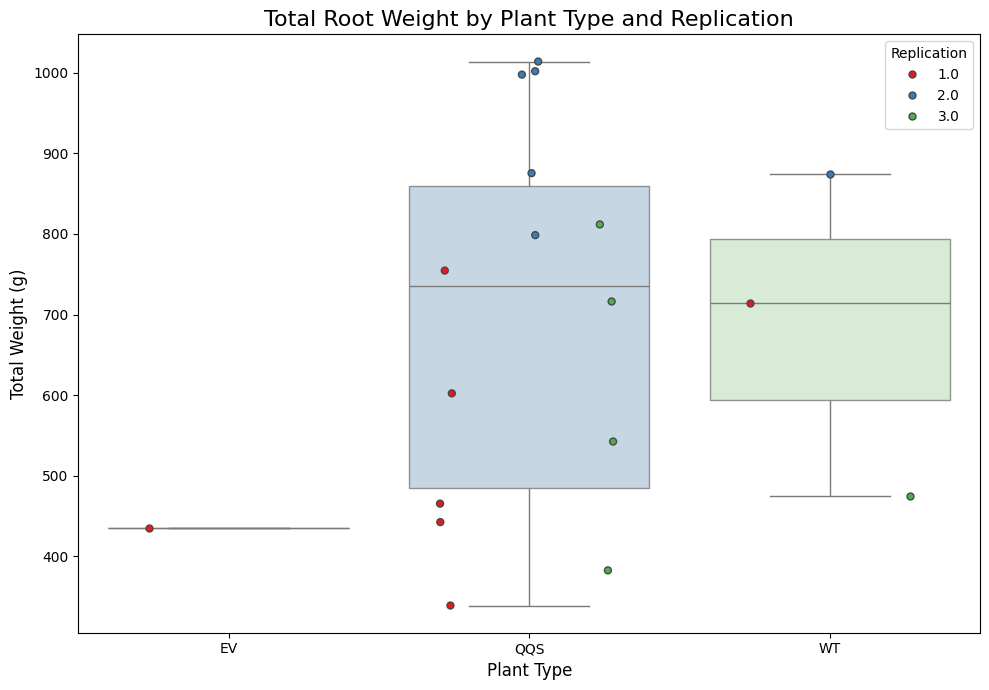

In [30]:
# --- 6. Generate and Save Plot ---
plt.figure(figsize=(10, 7))

# Boxplot to show the distribution for each plant type
sns.boxplot(x='Plant_Type', y='Total_Weight_g', data=clean_df, 
            palette='Pastel1', boxprops=dict(alpha=.8))

# Stripplot to show individual data points, colored by replication
sns.stripplot(x='Plant_Type', y='Total_Weight_g', hue='Replication', 
              data=clean_df, jitter=True, dodge=True, palette='Set1',
              linewidth=1, edgecolor='gray')

plt.title('Total Root Weight by Plant Type and Replication', fontsize=16)
plt.ylabel('Total Weight (g)', fontsize=12)
plt.xlabel('Plant Type', fontsize=12)
plt.legend(title='Replication')
plt.tight_layout()

# Save the figure
plt.savefig('plant_weight_comparison.png')
print("\nPlot saved as 'plant_weight_comparison.png'")